In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import mapel.elections as mapel
from scripts.gurobi import gurobi_ilp

from tqdm.notebook import tqdm

import time

plt.rcParams['figure.dpi'] = 140

In [2]:
!export GRB_LICENSE_FILE=/Users/janix4000/Configs/gurobi.lic
!echo $GRB_LICENSE_FILE

In [3]:
def get_approvalwise_vector(election: mapel.ApprovalElection) -> np.ndarray:
    vector = np.zeros(election.num_candidates)
    for vote in election.votes:
        vector[list(vote)] += 1
    vector[::-1].sort()
    return vector

def get_approvalwise_vectors(experiment) -> list[np.ndarray]:
    return [get_approvalwise_vector(election) for election in experiment.elections.values()]

def sample_elections_from_approval_vector(approvalwise_vector: np.ndarray, num_voters: int) -> mapel.ApprovalElection:
    num_candidates = len(approvalwise_vector)
    votes = [set() for _ in range(num_voters)]
    for candidate_idx, candidate_score in zip(range(num_candidates - 1, -1, -1), approvalwise_vector):
        candidates_votes_indices = np.random.choice(num_voters, size=int(candidate_score), replace=False)
        for voter_idx in candidates_votes_indices:
            votes[voter_idx].add(candidate_idx)
            
    return mapel.generate_approval_election_from_votes(votes)


def add_compass(experiment: mapel.ApprovalElectionExperiment, extended: bool = False):
    experiment.add_election(culture_id='full', election_id = 'FULL', color='red')
    experiment.add_election(culture_id='empty', election_id = 'EMPTY', color='blue')
    experiment.add_election(culture_id='ic', params={'p': 0.5}, election_id = 'IC 0.5', color='green')
    experiment.add_election(culture_id='id', params={'p': 0.5}, election_id = 'ID 0.5', color='orange')
    
    experiment.add_empty_family(family_id='compass')
    
    sample_election = next(iter(experiment.elections.values()))
    num_candidates = sample_election.num_candidates
    num_voters = sample_election.num_voters

    if extended:
        for p in np.linspace(0, 1, 11):
            for phi in np.linspace(0, 1, 11):
                election = mapel.generate_approval_election(
                    election_id=f'p={p:.1f}, phi={phi:.1}',
                    num_candidates=num_candidates, 
                    num_voters=num_voters, 
                    culture_id='resampling', 
                    params={'p': p, 'phi': phi}
                    )
                experiment.add_election_to_family(election, family_id='compass')

def show_2d_map_with_compass(experiment: mapel.ApprovalElectionExperiment, extended: bool = False, show_legend: bool = True):
    add_compass(experiment, extended=extended)
    experiment.compute_distances(distance_id='l1-approvalwise')
    experiment.embed_2d(embedding_id="fr")
    experiment.print_map_2d(legend=show_legend)
    

    
def generate_farthest_elections_l1_approvalwise(experiment: mapel.ApprovalElection, num_generated: int):
    approvalwise_vectors = get_approvalwise_vectors(experiment)
    new_approval_vectors = []
    new_distances = []
    execution_times = []
    
    family_id='New farthest elections'
    experiment.add_empty_family(family_id=family_id, color='orange')
    
    current_experiment_size = len(experiment.elections)

    experiment_sizes = list(range(current_experiment_size, current_experiment_size + num_generated))

    for idx in tqdm(range(num_generated)):
        start = time.time()
        
        sub_approvalwise_vectors = approvalwise_vectors[:]
        approvalwise_vector, distance = gurobi_ilp(sub_approvalwise_vectors, num_voters)
        new_approval_vectors.append(approvalwise_vector)
        new_distances.append(distance)
        election = sample_elections_from_approval_vector(approvalwise_vector, num_voters)
        
        execution_times.append(time.time() - start)
        
        election.instance_id = f'ILP-{idx}'
        election.num_candidates = num_candidates
        
        approvalwise_vectors.append(approvalwise_vector)
        experiment.add_election_to_family(election, family_id=family_id)
    
    report = pd.DataFrame({
        'experiment_size': experiment_sizes,
        'execution_time': execution_times,
        'distance': new_distances
    })

    return new_approval_vectors, report

def plot_report(report: pd.DataFrame): 
    plt.scatter(report.experiment_size, report.distance)
    plt.plot(report.experiment_size, report.distance, '--')
    plt.title('Distance to the closest election')
    plt.xlabel('Experiment size')
    plt.ylabel('Distance to the closest election')
    plt.show()

    plt.scatter(report.experiment_size, report.execution_time)
    plt.plot(report.experiment_size, report.execution_time, '--')
    plt.title('Execution time')
    plt.xlabel('Experiment size')
    plt.ylabel('Execution time [s]')
    plt.show()

# Approval online experiments

In [4]:
num_candidates = 10
num_voters = 100

def prepare_experiment() -> mapel.ApprovalElectionExperiment:
    experiment = mapel.prepare_online_approval_experiment(
        distance_id="l1-approvalwise",
        embedding_id="fr"
    )

    experiment.set_default_num_candidates(num_candidates)
    experiment.set_default_num_voters(num_voters)
    
    return experiment



## Simple disjoint resampling

In [5]:
experiment = prepare_experiment()
experiment.add_family(culture_id='disjoint_resampling', size=15, params={'p': 0.08, 'phi': 0.8, 'g': 10}, family_id='dr_1', color='green')
experiment.add_family(culture_id='disjoint_resampling', size=15, params={'p': 0.1, 'phi': 0.1, 'g': 5}, family_id='dr_2', color='green')
experiment.add_family(culture_id='disjoint_resampling', size=15, params={'p': 0.001, 'phi': 0.1, 'g': 20}, family_id='dr_3', color='green')

None

Computing distances: 100%|██████████| 9730/9730 [00:02<00:00, 4699.37it/s]


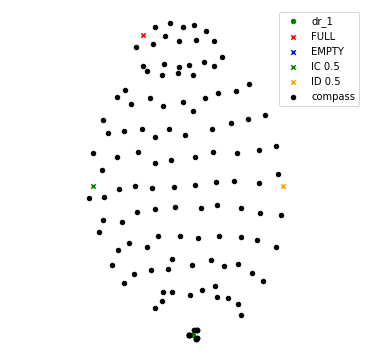

In [30]:
show_2d_map_with_compass(experiment, extended=True, show_legend=True)

## Disjoint resampling

  0%|          | 0/12 [00:00<?, ?it/s]

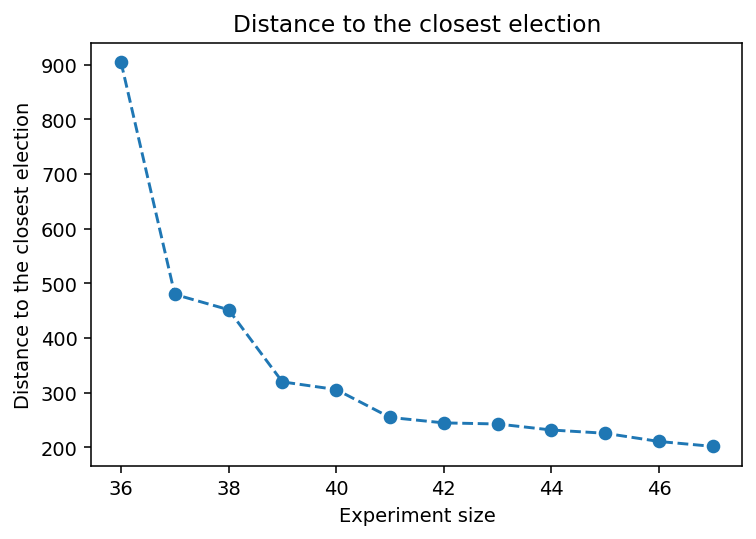

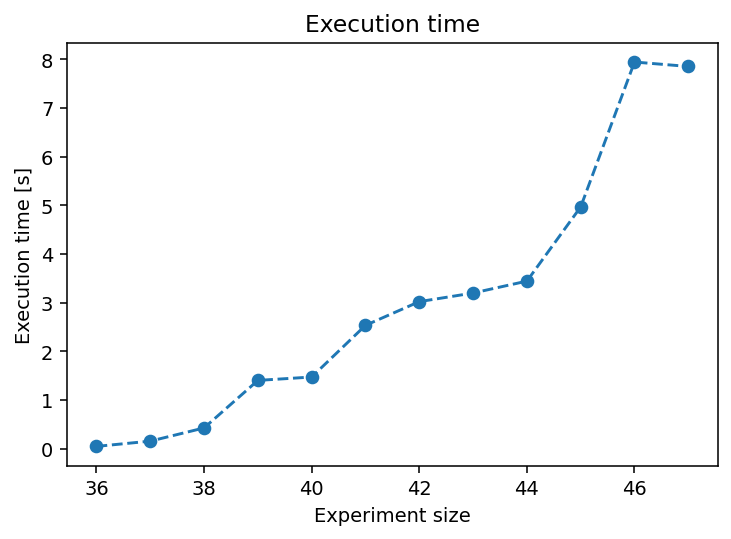

In [29]:
num_generated = 12

experiment = prepare_experiment()
num_families = 4
for g in range(2, 6 + 1, 2):
    for phi in np.linspace(0, 1, num_families):
        experiment.add_family(culture_id='disjoint_resampling', size=3, params={'p': 0.08, 'phi': phi, 'g': g}, family_id=f'dr_{g}_{phi:.2f}', color='green')
    
new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)
    

Computing distances: 100%|██████████| 14878/14878 [00:02<00:00, 5132.52it/s]


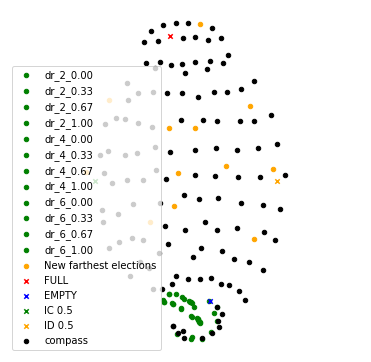

In [38]:
show_2d_map_with_compass(experiment, extended=True, show_legend=True)

## Noise resampling

  0%|          | 0/12 [00:00<?, ?it/s]

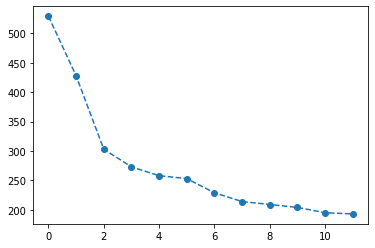

In [6]:
num_generated = 12

experiment = prepare_experiment()
experiment.add_family(culture_id='noise', size=15, params={'p': 0.08, 'phi': 0.8}, family_id='noise_1', color='green')
experiment.add_family(culture_id='noise', size=15, params={'p': 0.1, 'phi': 0.1}, family_id='noise_2', color='green')
experiment.add_family(culture_id='noise', size=15, params={'p': 0.001, 'phi': 0.1}, family_id='noise_3', color='green')


new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)
    

Computing distances: 100%|██████████| 16471/16471 [00:03<00:00, 4479.68it/s]


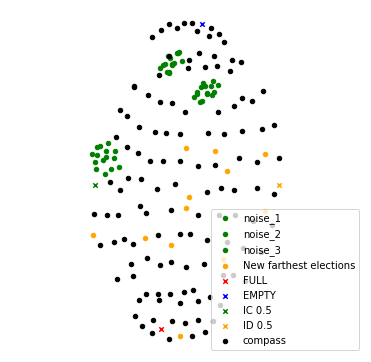

In [7]:
show_2d_map_with_compass(experiment, extended=True, show_legend=True)

## Euclidean

  0%|          | 0/12 [00:00<?, ?it/s]

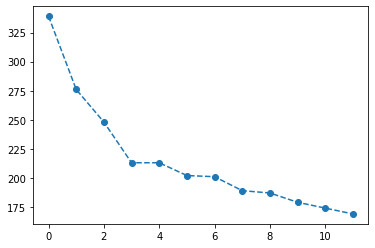

In [8]:
num_generated = 12

experiment = prepare_experiment()
num_families = 8
for radius in np.linspace(0.05, 0.5, num_families):
    experiment.add_family(culture_id='euclidean', size=5, family_id=f'euclidean_2d_r={radius:.2f}', color='green', params={'radius': radius, 'phi': 0.8})
    experiment.add_family(culture_id='euclidean', size=5, family_id=f'euclidean_1d_r={radius:.2f}', color='blue', params={'radius': radius, 'dim': 1, 'phi': 0.8})
    

new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)
    

Computing distances: 100%|██████████| 23436/23436 [00:05<00:00, 4337.29it/s]


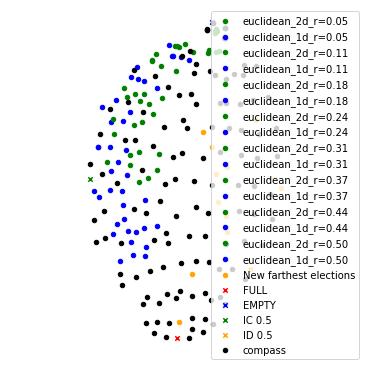

In [9]:
show_2d_map_with_compass(experiment, extended=True, show_legend=True)

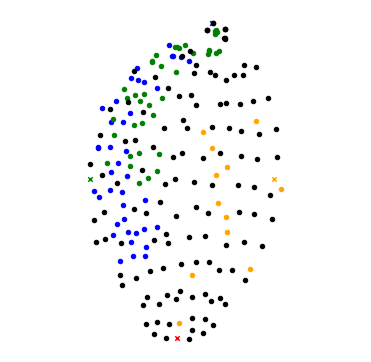

In [11]:
experiment.print_map_2d(legend=False)

## Euclidean simple

  0%|          | 0/12 [00:00<?, ?it/s]

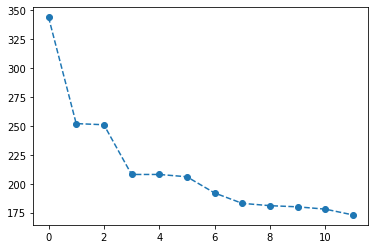

In [13]:
num_generated = 12

experiment = prepare_experiment()
    

experiment.add_family(culture_id='euclidean', size=25, family_id='euclidean_1', color='green', params={'radius': 0.9, 'phi': 0.8})
experiment.add_family(culture_id='euclidean', size=25, family_id='euclidean_2', color='green', params={'radius': 0.5, 'phi': 0.8})
experiment.add_family(culture_id='euclidean', size=25, family_id='euclidean_3', color='green', params={'radius': 0.1, 'phi': 0.8})


new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)
    

Computing distances: 100%|██████████| 22366/22366 [00:05<00:00, 3898.21it/s]


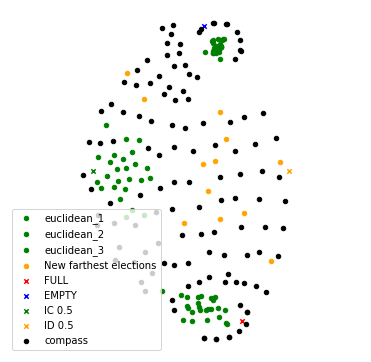

In [14]:
show_2d_map_with_compass(experiment, extended=True, show_legend=True)

# Euclidean Huge

In [5]:
num_generated = 12

experiment = prepare_experiment()
    

experiment.add_family(culture_id='euclidean', size=33, family_id='euclidean_1', color='green', params={'radius': 0.9, 'phi': 0.8})
experiment.add_family(culture_id='euclidean', size=31, family_id='euclidean_2', color='green', params={'radius': 0.5, 'phi': 0.8})
experiment.add_family(culture_id='euclidean', size=30, family_id='euclidean_3', color='green', params={'radius': 0.1, 'phi': 0.8})


new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)
    

  0%|          | 0/12 [00:00<?, ?it/s]


Interrupt request received


# Compass

  0%|          | 0/12 [00:00<?, ?it/s]

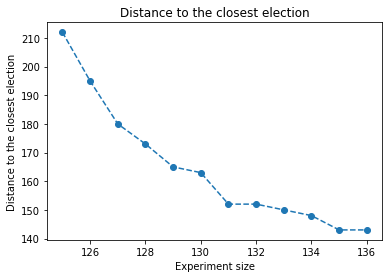

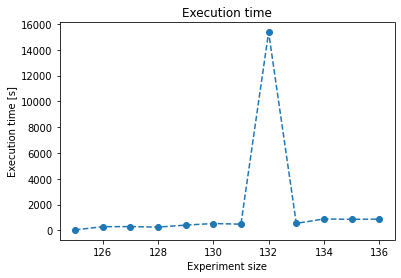

In [6]:
num_generated = 12

experiment = prepare_experiment()

add_compass(experiment, extended=True)

new_approval_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated)
plot_report(report)

Computing distances: 100%|██████████| 9316/9316 [00:02<00:00, 4257.18it/s]


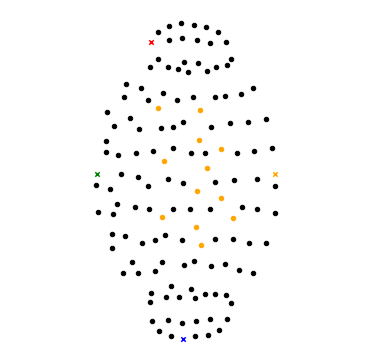

In [7]:
experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d(legend=False)

# Offline elections

In [145]:
experiment_50_100 = mapel.prepare_offline_approval_experiment(
    experiment_id='50x100/euclidean',
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment_50_100.prepare_elections()

Preparing instances: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


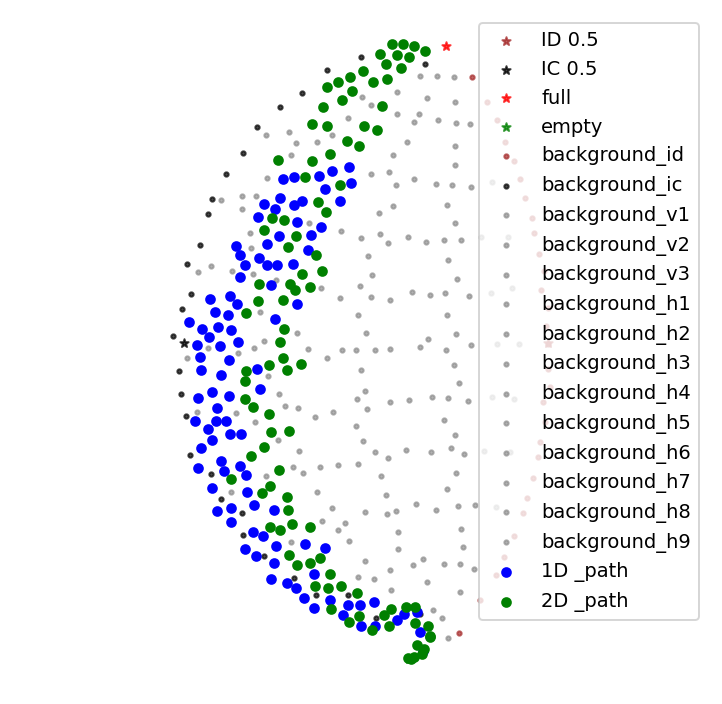

In [146]:
experiment_50_100.print_map_2d()

In [152]:
experiment.add_election_to_family()

AttributeError: 'NoneType' object has no attribute 'instance_id'